# **Deteksi Masker Menggunakan CNN - MobileNetV2**

Program *Machine Learning* (*Deep Learning*) untuk mendeteksi pemakaian masker wajah. Program dibuat menggunakan metode CNN dengan arsitektur MobileNetV2.

## Mengimpor *Library*

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from shutil import copyfile
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## *Preprocessing* Dataset

In [2]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch Pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [3]:
# Mengetahui jumlah citra pada data train menggunakan masker dengan tidak menggunakan masker
print("Jumlah gambar dengan masker wajah:",len(os.listdir('deteksi masker/train/with_mask')))
print("Jumlah gambar tanpa masker wajah:",len(os.listdir('deteksi masker/train/without_mask')))

Jumlah gambar dengan masker wajah: 341
Jumlah gambar tanpa masker wajah: 275


In [4]:
# Mengetahui jumlah citra pada data train dan persentasenya
def data_summary(main_path):
    
    yes_path = main_path+'with_mask'
    no_path = main_path+'without_mask'
    
    # Jumlah representasi data positif
    m_pos = len(listdir(yes_path))
    # Jumlah representasi data negatif
    m_neg = len(listdir(no_path))
    # Jumlah semua data
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos*100.0)/m
    neg_prec = (m_neg*100.0)/m
    
    print(f"Jumlah semua data: {m}")
    print(f"Persentasi data positif: {pos_prec}%, dengan jumlah data positif: {m_pos}") 
    print(f"Persentasi data negatif: {neg_prec}%, dengan jumlah data negatif: {m_neg}") 
    
augmented_data_path = 'deteksi masker/train/'    
data_summary(augmented_data_path)

Jumlah semua data: 616
Persentasi data positif: 55.357142857142854%, dengan jumlah data positif: 341
Persentasi data negatif: 44.642857142857146%, dengan jumlah data negatif: 275


In [5]:
# Me-split data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  dataset = []

  for unitData in os.listdir(SOURCE):
    data = SOURCE + unitData
    if(os.path.getsize(data) > 0):
      dataset.append(unitData)
    else:
      print('Skipped ' + unitData)
      print('Invalid file i.e zero size')
  
  train_set_length = int(len(dataset) * SPLIT_SIZE)
  test_set_length = int(len(dataset) - train_set_length)
  train_set = dataset[0:train_set_length]
  test_set = dataset[-test_set_length:]
  
  for unitData in train_set:
    temp_train_set = SOURCE + unitData
    final_train_set = TRAINING + unitData
    copyfile(temp_train_set, final_train_set)
  
  for unitData in test_set:
    temp_test_set = SOURCE + unitData
    final_test_set = TESTING + unitData
    copyfile(temp_test_set, final_test_set)
    
YES_SOURCE_DIR = "deteksi masker/source/with_mask/"
TRAINING_YES_DIR = "deteksi masker/train/with_mask/"
TESTING_YES_DIR = "deteksi masker/test/with_mask/"
NO_SOURCE_DIR = "deteksi masker/source/without_mask/"
TRAINING_NO_DIR = "deteksi masker/train/without_mask/"
TESTING_NO_DIR = "deteksi masker/test/without_mask/"

split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [6]:
# Menampilkan jumlah citra pada data train dan test
print("Jumlah gambar dengan masker wajah di set training berlabel 'yes':", len(os.listdir('deteksi masker/train/with_mask')))
print("Jumlah gambar dengan masker wajah di set test berlabel 'yes':", len(os.listdir('deteksi masker/test/with_mask')))
print("Jumlah gambar tanpa masker wajah di set training berlabel 'no':", len(os.listdir('deteksi masker/train/without_mask')))
print("Jumlah gambar tanpa masker wajah di set test berlabel 'no':", len(os.listdir('deteksi masker/test/without_mask')))

Jumlah gambar dengan masker wajah di set training berlabel 'yes': 377
Jumlah gambar dengan masker wajah di set test berlabel 'yes': 118
Jumlah gambar tanpa masker wajah di set training berlabel 'no': 375
Jumlah gambar tanpa masker wajah di set test berlabel 'no': 182


### Membuat objek ImageDataGenerator dan Data Augmentasi

In [7]:
# Membentuk training image generator untuk data augmentation
TRAINING_DIR = "deteksi masker/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=BS, 
                                                    target_size=(150, 150))

# Membentuk validation image generator
VALIDATION_DIR = "deteksi masker/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                              batch_size=BS, 
                                                              target_size=(150, 150))
                                                              
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 752 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Membuat Model Jaringan CNN

In [8]:
# Arsitektur jaringan MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

### *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama.

In [9]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

## Tahap Pembuatan Model

In [10]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3))(headModel)
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(50, activation="relu")(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Perulangan pada seluruh base model
for layer in baseModel.layers:
	layer.trainable = False

# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print(model.summary())

Mengkompilasi model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_C

### Melakukan Pelatihan Model

In [11]:
# Pelatihan model
print("Training head model...")
H = model.fit(train_generator,
              epochs=EPOCHS,
              validation_data=validation_generator,
              callbacks=[checkpoint])

Training head model...
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8896INFO:tensorflow:Assets written to: model-001.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 32s 1s/step - loss: 0.3647 - accuracy: 0.8896 - val_loss: 0.0643 - val_accuracy: 0.9767
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9614INFO:tensorflow:Assets written to: model-002.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 32s 1s/step - loss: 0.1063 - accuracy: 0.9614 - val_loss: 0.0250 - val_accuracy: 0.9900
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9761INFO:tensorflow:Assets written to: model-003.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 32s 1s/step - loss: 0.0824 - accuracy: 0.9761 - val_loss: 0.0186 - val_accuracy: 0.9967
Epoch 4/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0856 - accuracy: 0.9747 - val_loss: 0.0242 - val_accuracy: 0.9900
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9827INFO:tensorflow:Assets written to: model-005.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 30s 1s/step - loss: 0.0564 - accuracy: 0.9827 - val_loss: 0.0174 - val_accuracy: 0.9933
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9761INFO:tensorflow:Assets written to: model-006.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 31s 1s/step - loss: 0.0704 - accuracy: 0.9761 - val_loss: 0.0142 - val_accuracy: 0.9933
Epoch 7/10
24/24 [==============================] - 12s 492ms/step - loss: 0.0591 - accuracy: 0.9854 - val_loss: 0.0146 - val_accuracy: 0.9967
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9867INFO:tensorflow:Assets written to: model-008.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 30s 1s/step - loss: 0.0486 - accuracy: 0.9867 - val_loss: 0.0129 - val_accuracy: 0.9967
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9867INFO:tensorflow:Assets written to: model-009.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 30s 1s/step - loss: 0.0509 - accuracy: 0.9867 - val_loss: 0.0129 - val_accuracy: 0.9967
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9827INFO:tensorflow:Assets written to: model-010.model\assets


C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


24/24 [==============================] - 30s 1s/step - loss: 0.0519 - accuracy: 0.9827 - val_loss: 0.0085 - val_accuracy: 0.9967


### Menampilkan Kurva Model Hasil Pelatihan

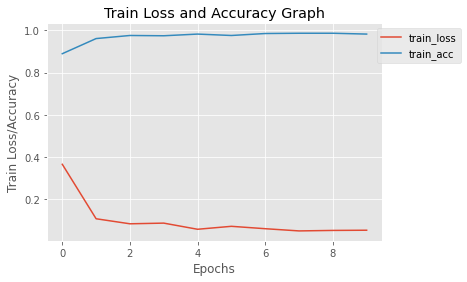

In [12]:
# Kurva train loss/accuracy
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n), H.history["accuracy"], label="train_acc")
plt.title("Train Loss and Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Train Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot_train.png")

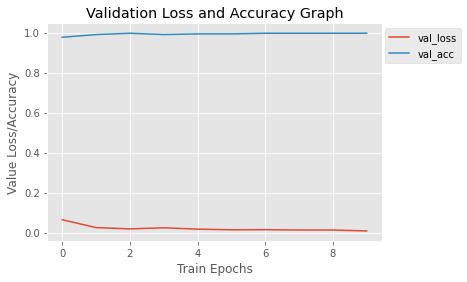

In [13]:
# Kurva validation loss/accuracy
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n), H.history["val_accuracy"], label="val_acc")
plt.title("Validation Loss and Accuracy Graph")
plt.xlabel("Train Epochs")
plt.ylabel("Value Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot_value.png")

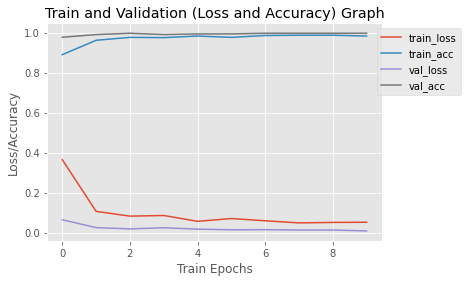

In [14]:
# Kurva train dan validation loss/accuracy
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n), H.history["val_accuracy"], label="val_acc")
plt.title("Train and Validation (Loss and Accuracy) Graph")
plt.xlabel("Train Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot_train_value.png")

### Evaluasi Jaringan

In [15]:
# Evaluasi train loss dan accuracy
modelTLoss, modelTAccuracy = model.evaluate(train_generator)

print('Train Loss: {}'.format(modelTLoss))
print('Train Accuracy: {}'.format(modelTAccuracy ))

24/24 [==============================] - 9s 351ms/step - loss: 0.0183 - accuracy: 0.9920
Train Loss: 0.018291091546416283
Train Accuracy: 0.9920212626457214


In [16]:
# Evaluasi test loss dan accuracy
modelLoss, modelAccuracy = model.evaluate(validation_generator)

print('Test Loss: {}'.format(modelLoss))
print('Test Accuracy: {}'.format(modelAccuracy ))

10/10 [==============================] - 2s 231ms/step - loss: 0.0085 - accuracy: 0.9967
Test Loss: 0.008478653617203236
Test Accuracy: 0.996666669845581


## Melakukan Pengujian dengan WebCam menggunakan OpenCV

In [17]:
labels_dict={0:'Dengan Masker',1:'Tanpa Masker'}
color_dict={0:(0,255,0),1:(0,0,255)}

size = 4
webcam = cv2.VideoCapture(2) # Ubah value untuk menyesuaikan source kamera

# Meload file xml
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) # Flip ke act sebagai mirror

    # Resize citra untuk mempercepat pendeteksian
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # Mendeteksi multiScale / banyak wajah
    faces = classifier.detectMultiScale(mini)

    # Menandai kotak disekitar area wajah
    for f in faces:
        (x, y, w, h) = [v * size for v in f] # Scale shapesize
        # Menyimpan hanya kotak wajah ke SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized = cv2.resize(face_img,(150,150))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result = model.predict(reshaped)
        # print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Menampilkan citra
    cv2.imshow('Face Mask Detection', im)
    key = cv2.waitKey(10)
    # Tekan Esc key di keyboard untuk menghentikan loop dan keluar
    if key == 27: # Tombol Esc
        break
# Stop video
webcam.release()

# Menutup semua windows yang berjalan
cv2.destroyAllWindows()